In [1]:
# Adapted from https://github.com/jacobgil/pytorch-grad-cam/blob/master/usage_examples/vit_example.py
from pathlib import Path

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
from pytorch_grad_cam import GradCAM, GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
import matplotlib.pyplot as plt
import numpy as np
import cv2

from evaluate_model import label_to_correct_idxes
from imagenet_labels import imagenet_labels
from experiments.dataset import BGVarDataset, split_dataset

/cmlscratch/pkattaki/developer/pytorch/lib/python3.8/site-packages/clip/clip.py:23: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [2]:
num_examples_to_find = 6
model_checkpoint = "/cmlscratch/pkattaki/void/bg-var/logs/pretrained_dcr/dcr_resnet-epoch-20.pt"
bg_var_root = Path("/cmlscratch/pkattaki/datasets/focus")
BUCKET_URL = Path("https://bg-var-bucket.s3.amazonaws.com")
use_imagenet_labels = True

In [4]:
%%capture
base_model = models.resnet50(pretrained=True)
base_model.cuda()
base_model.eval()
gb_base_model = GuidedBackpropReLUModel(model=base_model, use_cuda=True)

finetuned_model = models.resnet50()
ckpt = torch.load("/cmlscratch/pkattaki/void/bg-var/logs/resnet-finetune/ckpt.pth")
finetuned_model.load_state_dict(ckpt["model_state_dict"])
finetuned_model.cuda()
finetuned_model.eval()

In [15]:
gb_finetuned_model = GuidedBackpropReLUModel(model=finetuned_model, use_cuda=True)

In [5]:
base_cam = GradCAM(model=base_model,
              target_layer=base_model.layer4[-1],
              use_cuda=True)

finetuned_cam = GradCAM(model=finetuned_model,
                  target_layer=finetuned_model.layer4[-1],
                  use_cuda=True)

In [6]:
    test_transform = T.Compose(
        [
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

In [7]:
categories = [
    "truck",
    "car",
    "plane",
    "ship",
    "cat",
    "dog",
    "horse",
    "deer",
    "frog",
    "bird",
]
times = [
    "day",
    "night",
    "none",
]

weathers = [
    "cloudy",
    "foggy",
    "partly cloudy",
    "raining",
    "snowing",
    "sunny",
    "none",
]

locations = [
    "forest",
    "grass",
    "indoors",
    "rocks",
    "sand",
    "street",
    "snow",
    "water",
    "none",
]
def is_correct_label(idx, ground_truth):
    return idx in label_to_correct_idxes[ground_truth]

In [8]:
def overlay_cam_image(cam, input_tensor, target_category, pil_image):
    grayscale_cam = cam(input_tensor=input_tensor,
                        target_category=target_category,
                        aug_smooth=True)
    
    grayscale_cam = grayscale_cam[0, :]
    
    cam_image = show_cam_on_image(np.array(pil_image).astype(np.float32) / 255.0,
                                  grayscale_cam,
                                  use_rgb=True)
    return cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam]), cam_image

In [8]:
def generate_cam_images(bg_var_test_dataset, model):
    cam_images = {"correct": [], "incorrect": []}
    gb_cam_images = {"correct": [], "incorrect": []}
    target_categories = {"correct": [], "incorrect": []}
    gt_labels = {"correct": [], "incorrect": []}
    image_paths = {"correct": [], "incorrect": []}
    for image_idx, (tensor_image, label, _, _, _) in enumerate(bg_var_test_dataset):
        try:
            image_file = bg_var_test_dataset.image_files[image_idx][0][1:]
        except AttributeError:
            image_file = bg_var_test_dataset.dataset.image_files[bg_var_test_dataset.indices[image_idx]][0][1:]
        image_path = bg_var_root / image_file
        pil_image = Image.open(image_path)
        if pil_image.mode != "RGB":
            pil_image = pil_image.convert("RGB")
        pil_image = T.Compose(
            [
                T.Resize(224),
                T.CenterCrop(224),
            ]
        )(pil_image)
        input_tensor = torch.unsqueeze(tensor_image, 0).cuda()
        outputs = model(input_tensor)
        _, idxs = torch.max(outputs, dim=1)
        idx = idxs[0].item()
        if not is_correct_label(idx, label) and len(cam_images["incorrect"]) != num_examples_to_find:
            image_paths["incorrect"].append(image_path)
            target_categories["incorrect"].append(imagenet_labels[idx] if use_imagenet_labels else DCR.classes[idx])
            gt_labels["incorrect"].append(DCR.classes[label])

            cam_mask, cam_image = overlay_cam_image(cam, input_tensor, idx, pil_image)
            cam_gb = deprocess_image(cam_mask * gb_model(input_tensor, target_category=idx))
            cam_images["incorrect"].append(cam_image)
            gb_cam_images["incorrect"].append(cam_gb)
#         elif len(cam_images["incorrect"]) == num_examples_to_find:
#             break
            

        elif is_correct_label(idx, label) and len(cam_images["correct"]) != num_examples_to_find:
            image_paths["correct"].append(image_path)
            target_categories["correct"].append(imagenet_labels[idx] if use_imagenet_labels else DCR.classes[idx])
            gt_labels["correct"].append(DCR.classes[label])

            cam_image = overlay_cam_image(cam, input_tensor, idx, pil_image)
            cam_images["correct"].append(cam_image)
        elif len(cam_images["incorrect"]) == num_examples_to_find and len(cam_images["correct"]) == num_examples_to_find:
            break
            
    return cam_images, gb_cam_images, target_categories, gt_labels, image_paths, len(cam_images["incorrect"])

In [31]:
def find_candidates(bg_var_test_dataset):
    cam_images = {"correct": [], "incorrect": []}
    gb_cam_images = {"correct": [], "incorrect": []}
    target_categories = {"correct": [], "incorrect": []}
    gt_labels = {"correct": [], "incorrect": []}
    image_paths = {"correct": [], "incorrect": []}
    candidates = []
    for image_idx, (tensor_image, label, _, _, _) in enumerate(bg_var_test_dataset):
        try:
            image_file = bg_var_test_dataset.image_files[image_idx][0][1:]
        except AttributeError:
            image_file = bg_var_test_dataset.dataset.image_files[bg_var_test_dataset.indices[image_idx]][0][1:]
        image_path = bg_var_root / image_file
        pil_image = Image.open(image_path)
        if pil_image.mode != "RGB":
            pil_image = pil_image.convert("RGB")
        pil_image = T.Compose(
            [
                T.Resize(224),
                T.CenterCrop(224),
            ]
        )(pil_image)
        input_tensor = torch.unsqueeze(tensor_image, 0).cuda()
        base_outputs = base_model(input_tensor)
        _, base_idxs = torch.max(base_outputs, dim=1)
        base_idx = base_idxs[0].item()
        
        finetuned_outputs = finetuned_model(input_tensor)
        _, finetuned_idxs = torch.max(finetuned_outputs, dim=1)
        finetuned_idx = finetuned_idxs[0].item()
        if not is_correct_label(base_idx, label) and is_correct_label(finetuned_idx, label):
            candidates.append(image_path)
    return candidates

In [32]:
bg_var_test_dataset = BGVarDataset(
    bg_var_root,
    categories=categories,
    times=None,
    weathers=None,
    locations=None,
    transform=test_transform
)
train_set, test_set = split_dataset(bg_var_test_dataset, train_fraction=0.7)
candidates = find_candidates(test_set)

In [107]:
print(candidates[650:700])

[PosixPath('/cmlscratch/pkattaki/datasets/focus/car-street/487.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/car-water/244.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/truck-water/280.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/car-grass/91.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/deer-snow/152.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/horse-street/111.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/deer-grass/254.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/horse-night/222.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/horse-street/208.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/plane-indoors/543.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/deer-snow/122.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/car-fog/170.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/dog-rain/105.jpeg'), PosixPath('/cmlscratch/pkattaki/datasets/focus/horse-fog/160.jpeg'), PosixPath('/cmlscratc

In [9]:
def evaluate_combination(categories, time, weather, location):
    bg_var_test_dataset = BGVarDataset(
        bg_var_root,
        categories=categories,
        times=[time] if time is not None else None,
        weathers=[weather] if weather is not None else None,
        locations=[location] if location is not None else None,
        transform=test_transform
    )
    print(len(bg_var_test_dataset))
    gb_cam_images, cam_images, target_categories, gt_labels, image_paths, num_examples_found = generate_cam_images(bg_var_test_dataset)
    print(num_examples_found)
    for image_path in image_paths["incorrect"]:
        print(BUCKET_URL / image_path.parents[0].name / image_path.name)
    num_cols = 2
    num_rows = num_examples_found
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5), constrained_layout=True)
    fig.suptitle(f"Incorrectly classified Images in {time}-{weather}-{location}", fontsize=16)
    for i in range(num_rows):
        axs[i, 0].imshow(gb_cam_images["incorrect"][i])
        axs[i, 0].title.set_text(f"GT: {gt_labels['incorrect'][i]}, Predicted: {target_categories['incorrect'][i]}"[:35])
        axs[i, 1].imshow(cam_images["incorrect"][i])
        axs[i, 1].title.set_text(f"Guided GradCAM")

74


/cmlscratch/pkattaki/developer/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


6
https:/bg-var-bucket.s3.amazonaws.com/deer-street/489.jpg
https:/bg-var-bucket.s3.amazonaws.com/deer-grass/41.jpg
https:/bg-var-bucket.s3.amazonaws.com/deer-street/439.jpg
https:/bg-var-bucket.s3.amazonaws.com/deer-water/181.jpg
https:/bg-var-bucket.s3.amazonaws.com/deer-street/269.jpg
https:/bg-var-bucket.s3.amazonaws.com/deer-water/29.jpg


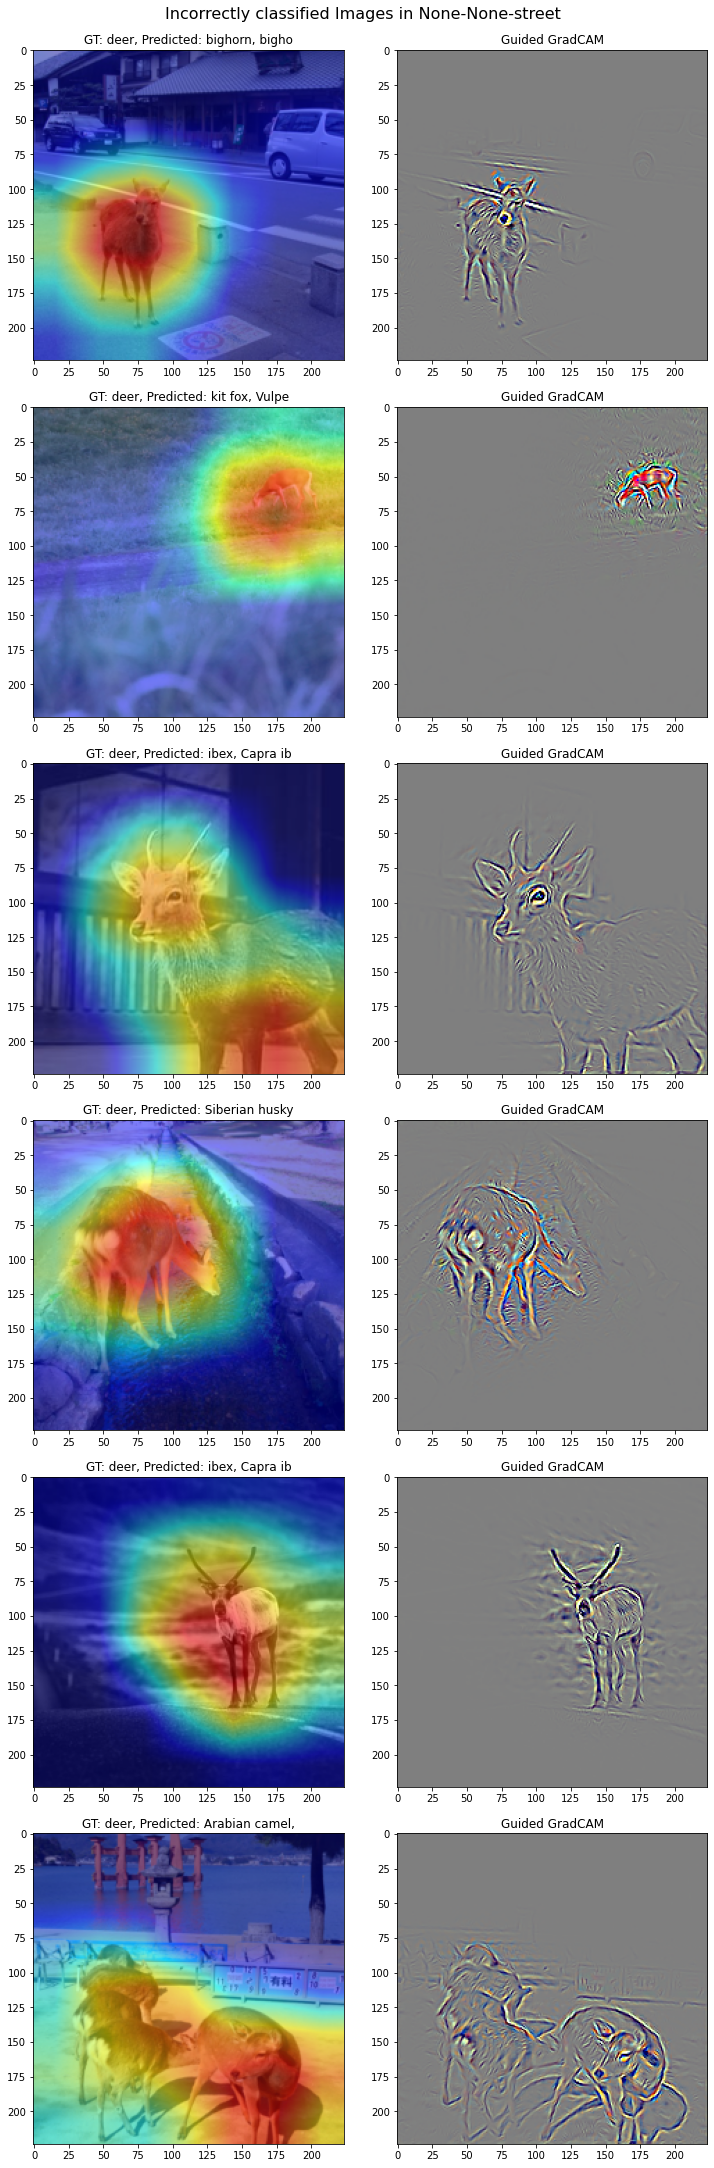

In [10]:
evaluate_combination([
        "deer"
    ],
    None,
    None,
    "street",
)

23902
3
https:/bg-var-bucket.s3.amazonaws.com/ship-night/91.jpg
https:/bg-var-bucket.s3.amazonaws.com/car-snow/55.png
https:/bg-var-bucket.s3.amazonaws.com/cat-street/404.jpg


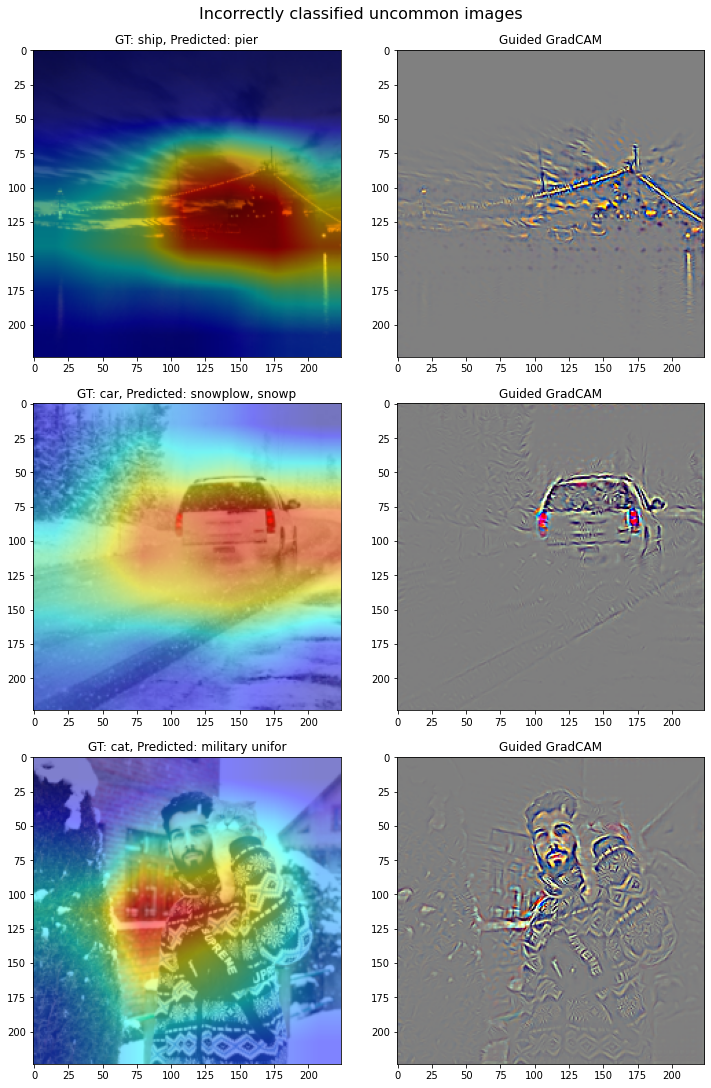

In [12]:

bg_var_test_dataset = BGVarDataset(
    bg_var_root,
    categories=categories,
    times=None,
    weathers=None,
    locations=None,
    transform=test_transform
)
print(len(bg_var_test_dataset))
bg_var_test_dataset = torch.utils.data.Subset(bg_var_test_dataset, [75, 119, 133, 157, 159])
gb_cam_images, cam_images, target_categories, gt_labels, image_paths, num_examples_found = generate_cam_images(bg_var_test_dataset)
print(num_examples_found)
for image_path in image_paths["incorrect"]:
    print(BUCKET_URL / image_path.parents[0].name / image_path.name)
num_cols = 2
num_rows = num_examples_found
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5), constrained_layout=True)
fig.suptitle(f"Incorrectly classified uncommon images", fontsize=16)
for i in range(num_rows):
    axs[i, 0].imshow(gb_cam_images["incorrect"][i])
    axs[i, 0].title.set_text(f"GT: {gt_labels['incorrect'][i]}, Predicted: {target_categories['incorrect'][i]}"[:35])
    axs[i, 1].imshow(cam_images["incorrect"][i])
    axs[i, 1].title.set_text(f"Guided GradCAM")

In [116]:
def generate_hq_cam(image_file, model, gb_model, cam, is_base=True):
    image_path = bg_var_root / image_file
    pil_image = Image.open(image_path)
    if pil_image.mode != "RGB":
        pil_image = pil_image.convert("RGB")
    pil_image = T.Compose(
        [
            T.Resize(224),
            T.CenterCrop(224),
        ]
    )(pil_image)
    input_tensor = torch.unsqueeze(test_transform(pil_image), 0).cuda()
    outputs = model(input_tensor)
    _, idxs = torch.max(outputs, dim=1)
    idx = idxs[0].item()
    predicted_label = imagenet_labels[idx]
    cam_mask, cam_image = overlay_cam_image(cam, input_tensor, idx, pil_image)
    cam_gb = deprocess_image(cam_mask * gb_model(input_tensor, target_category=idx))
    if is_base:
        fig, axs = plt.subplots(1, 3, figsize=(3 * 5, 5), constrained_layout=True)
        axs[0].imshow(np.asarray(pil_image))
        axs[0].axis("off")
        axs[1].imshow(cam_image)
        axs[1].axis("off")
        axs[2].imshow(cam_gb)
        axs[2].axis("off")
        fig.savefig(f"base_cam-vis-{image_file.replace('/', '-')}-{predicted_label}.pdf")
    else:
        fig, axs = plt.subplots(1, 2, figsize=(2 * 5, 5), constrained_layout=True)
        axs[0].imshow(cam_image)
        axs[0].axis("off")
        axs[1].imshow(cam_gb)
        axs[1].axis("off")
        fig.savefig(f"finetuned_cam-vis-{image_file.replace('/', '-')}-{predicted_label}.pdf")
    plt.show()
    print(predicted_label)


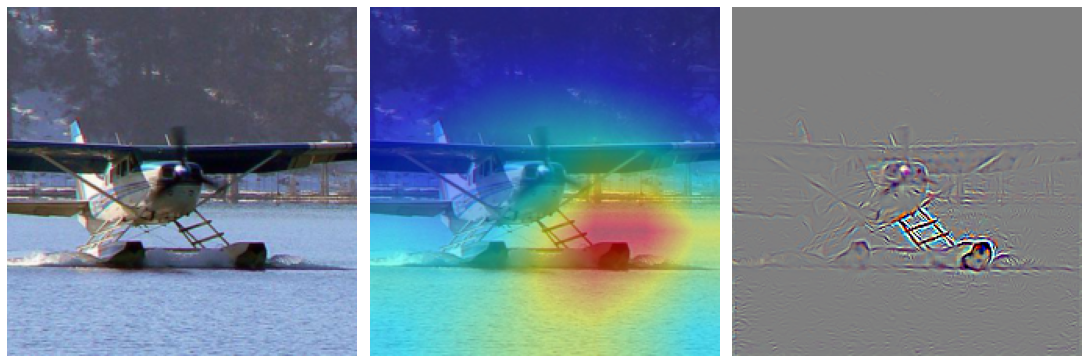

submarine, pigboat, sub, U-boat


In [129]:
generate_hq_cam("plane-water/232.jpeg", base_model, gb_base_model, base_cam)

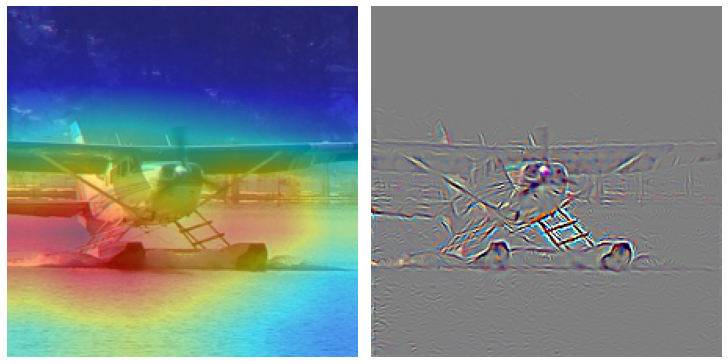

pirate, pirate ship


In [130]:
generate_hq_cam("plane-water/232.jpeg", finetuned_model, gb_finetuned_model, finetuned_cam, False)

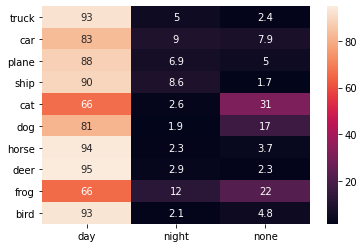

In [9]:
from itertools import product
import seaborn as sns
np.set_printoptions(precision=2)
freq_time = np.zeros((len(categories), len(times)))
for (cat_idx, category), (time_idx, time) in product(enumerate(categories), enumerate(times)):
    dataset = BGVarDataset(
        bg_var_root,
        categories=[category],
        times=[time],
        weathers=None,
        locations=None,
        transform=test_transform
    )
    freq_time[cat_idx, time_idx] = len(dataset)
heatmap = sns.heatmap(100 * freq_time / np.sum(freq_time, axis=1, keepdims=True),
            annot=True,
            xticklabels=times,
            yticklabels=categories,
           )
heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=30)
plt.save

<AxesSubplot:>

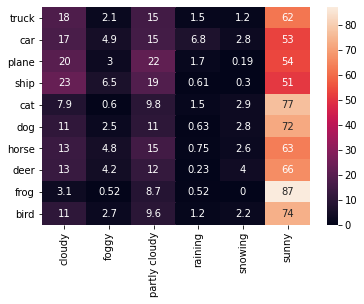

In [14]:
freq_weather = np.zeros((len(categories), len(weathers) - 1))
for (cat_idx, category), (weather_idx, weather) in product(enumerate(categories), enumerate(weathers[:-1])):
    dataset = BGVarDataset(
        bg_var_root,
        categories=[category],
        times=None,
        weathers=[weather],
        locations=None,
        transform=test_transform
    )
    freq_weather[cat_idx, weather_idx] = len(dataset)
sns.heatmap(100 * freq_weather / np.sum(freq_weather, axis=1, keepdims=True),
            annot=True,
            xticklabels=weathers[:-1],
            yticklabels=categories,
           )

<AxesSubplot:>

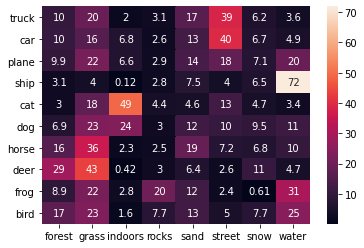

In [15]:
freq_locations = np.zeros((len(categories), len(locations) - 1))
for (cat_idx, category), (location_idx, location) in product(enumerate(categories), enumerate(locations[:-1])):
    dataset = BGVarDataset(
        bg_var_root,
        categories=[category],
        times=None,
        weathers=None,
        locations=[location],
        transform=test_transform
    )
    freq_locations[cat_idx, location_idx] = len(dataset)
sns.heatmap(100 * freq_locations / np.sum(freq_locations, axis=1, keepdims=True),
            annot=True,
            xticklabels=locations[:-1],
            yticklabels=categories,
           )

In [16]:
eval

<function eval(source, globals=None, locals=None, /)>